In [1]:
using BSON
using Flux
using HDF5
using Plots

In [2]:
include("ActiveLearning.jl")
include("DataSets.jl")
using .ActiveLearning
using .DataSets

In [3]:
X_mnist_train, y_mnist_train, X_mnist_test, y_mnist_test = prepare_mnist(get_mnist("data/mnist"))
size(X_mnist_train), size(X_mnist_test)

((32, 32, 1, 60000), (32, 32, 1, 10000))

In [4]:
rounds_random, accuracies_random = simulate_al(
    random_sampling, oracle,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 1
│   accuracy_round = 0.6515
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:72
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 2
│   accuracy_round = 0.7559
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:72
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 3
│   accuracy_round = 0.8305
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:72
┌ Warning: Number of observations less than batchsize, 

(0:30, [0.6352, 0.6515, 0.7559, 0.8305, 0.8597, 0.9043, 0.9002, 0.9143, 0.9201, 0.9218  …  0.9617, 0.9596, 0.9588, 0.9522, 0.9651, 0.9589, 0.964, 0.9612, 0.9651, 0.9629])

In [5]:
rounds_entropy, accuracies_entropy = simulate_al(
    entropy_sampling, oracle,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 1
│   accuracy_round = 0.7287
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:72
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 2
│   accuracy_round = 0.7535
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:72
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 3
│   accuracy_round = 0.7753
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:72
┌ Warning: Number of observations less than batchsize, 

(0:30, [0.6352, 0.7287, 0.7535, 0.7753, 0.766, 0.7979, 0.8408, 0.8547, 0.8902, 0.9291  …  0.9675, 0.9681, 0.9711, 0.9714, 0.9699, 0.9753, 0.9744, 0.9743, 0.9745, 0.9731])

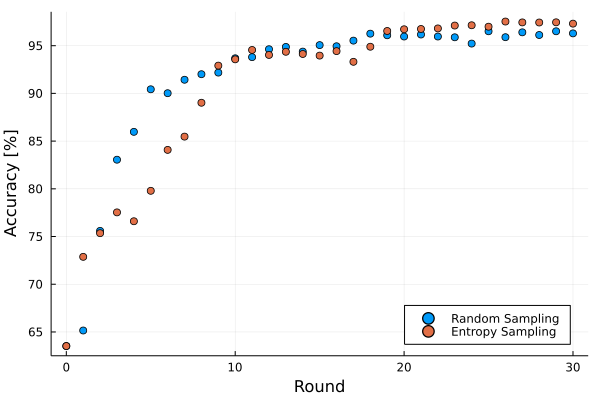

In [6]:
# TODO Run 30 runs to get error bars.
scatter(rounds_random, 100 .* accuracies_random, label="Random Sampling",
    legend_position=:bottomright, xlabel="Round", ylabel="Accuracy [%]")
scatter!(rounds_entropy, 100 .* accuracies_entropy, label="Entropy Sampling")

In [ ]:
file = "data/human_labeller.hdf5"
h5open(file, "w") do datafile
    write(datafile, "X", X_mnist_train)
    write(datafile, "y", y_mnist_train)
end

function human_labeller_wrap(index_query, round)
    human_labeller(index_query, round, y_mnist_train, file)
end 

rounds_human, accuracies_human = simulate_al(
    entropy_sampling, human_labeller_wrap,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test,
    n_query=1000)